# Bursting analysis of the Hindmarsh-Rose model

The Hindmarsh-Rose model describes bursting dynamics in neurons.

"x" models the membrane potential of a bursting cell,
"y" models the main currents into and out of the cell, and
"z" models an adaptive (calcium-like) current.

In [1]:
import brainpy as bp
import numpy as np

bp.profile.set(dt=0.02, numerical_method='rk4')


def get_model(a=1., b=3., c=1., d=5., s=4., x_r=-1.6, r=0.001, Vth=1.9):
    state = bp.types.NeuState({'x': 0., 'y': 0., 'z': 0.,
                               'spike': 0., 'input': 0.})

    @bp.integrate
    def int_x(x, t, y, z, Isyn):
        return y - a * x ** 3 + b * x * x - z + Isyn

    @bp.integrate
    def int_y(y, t, x):
        return c - d * x * x - y

    @bp.integrate
    def int_z(z, t, x):
        return r*(s * (x - x_r) - z)

    def update(ST, _t):
        ST['y'] = int_y(ST['y'], _t, ST['x'])
        ST['z'] = int_z(ST['z'], _t, ST['x'])
        x = int_x(ST['x'], _t, ST['y'], ST['z'], ST['input'])
        ST['spike'] = np.logical_and(x >= Vth, ST['x'] < Vth)
        ST['x'] = x
        ST['input'] = 0.

    return bp.NeuType(name='Hindmarsh_Rose_model',
                      ST=state,
                      steps=update)

### Simulation

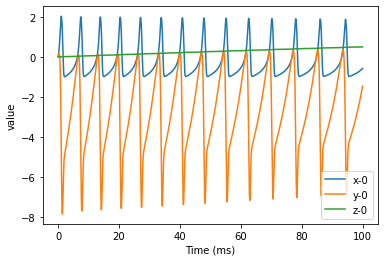

In [2]:
neuron = get_model()

group = bp.NeuGroup(neuron, 1, monitors=['x', 'y', 'z'])
group.run(100., inputs=('ST.input', 1.))
bp.visualize.line_plot(group.mon.ts, group.mon.x, legend='x', )
bp.visualize.line_plot(group.mon.ts, group.mon.y, legend='y', )
bp.visualize.line_plot(group.mon.ts, group.mon.z, legend='z', show=True)

### Phase plane analysis

SymPy solve "int_y(x, y) = 0" to "y = f(x, )", success.
SymPy solve "int_x(x, y) = 0" to "y = f(x, )", success.
SymPy solve derivative of "int_x(x, y)" by "x", success.
SymPy solve derivative of "int_x(x, y)" by "y", success.
SymPy solve derivative of "int_y(x, y)" by "x", success.
SymPy solve derivative of "int_y(x, y)" by "y", success.
Fixed point #1 at x=0.8392867552141227, y=-2.5220112873892533 is a unstable-focus.


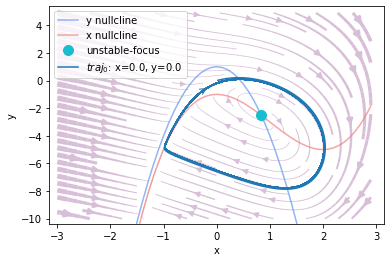

In [3]:
analyzer = bp.analysis.PhasePlane(
    model=neuron,
    target_vars={'x': [-3, 3], 'y': [-10., 5.]},
    fixed_vars={'Isyn': 1., 'z': 0.})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'x': 0., 'y': 0.}],
                         duration=100.,
                         inputs=('ST.input', 1.),
                         show=True)

### Codimension 1 bifurcation analysis

SymPy solve "int_y(x, y, Isyn) = 0" to "y = f(x, Isyn)", success.
SymPy solve derivative of "int_x(x, y, Isyn)" by "x", success.
SymPy solve derivative of "int_x(x, y, Isyn)" by "y", success.
SymPy solve derivative of "int_y(x, y, Isyn)" by "x", success.
SymPy solve derivative of "int_y(x, y, Isyn)" by "y", success.


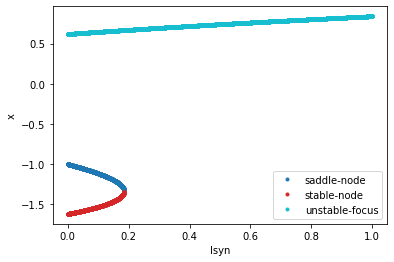

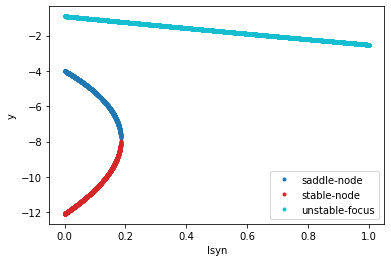

In [4]:
analyzer = bp.analysis.Bifurcation(
    model=neuron,
    target_pars={'Isyn': [0., 1.]},
    target_vars={'x': [-3, 3], 'y': [-10., 5.]},
    fixed_vars={'z': 0.},
    numerical_resolution=0.0001,
)
analyzer.plot_bifurcation(show=True)

### Codimension 2 bifurcation analysis

SymPy solve "int_y(x, y, Isyn, a) = 0" to "y = f(x, Isyn,a)", success.
SymPy solve derivative of "int_x(x, y, Isyn, a)" by "x", success.
SymPy solve derivative of "int_x(x, y, Isyn, a)" by "y", success.
SymPy solve derivative of "int_y(x, y, Isyn, a)" by "x", success.
SymPy solve derivative of "int_y(x, y, Isyn, a)" by "y", success.


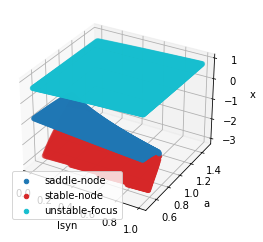

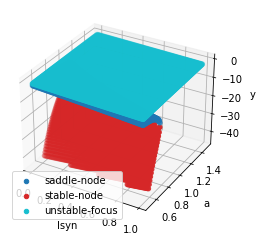

In [5]:
analyzer = bp.analysis.Bifurcation(
    model=neuron,
    target_pars={'Isyn': [0., 1.], 'a': [0.5, 1.5]},
    target_vars={'x': [-3, 3], 'y': [-10., 5.]},
    fixed_vars={'z': 0.},
    numerical_resolution=0.01,
)
analyzer.plot_bifurcation(show=True)

**References**:

James L Hindmarsh and RM Rose. A model of neuronal bursting using
three coupled first order differential equations. Proceedings
of the Royal society of London. Series B. Biological sciences,
221(1222):87–102, 1984.